In [7]:
urls = ["https://www.nytimes.com/2024/09/29/us/north-carolina-helene-relief-damage.html","https://www.faz.net/aktuell/wirtschaft/kuenstliche-intelligenz/today-s-ai-can-t-be-trusted-19532136.html","http://www.chinatoday.com.cn/ctenglish/2018/commentaries/202409/t20240925_800378506.html","https://english.elpais.com/economy-and-business/2024-09-28/from-the-hermes-heir-to-nicolas-cage-millionaires-who-went-bankrupt.html","https://insatiable.info/2023/06/30/quels-futur-pour-les-reseaux-sociaux/","https://actu.fr/auvergne-rhone-alpes/lyon_69123/lyon-le-projet-de-reamenagement-des-quais-les-plus-mortels-pour-les-cyclistes-devoile_61667371.html"]

In [10]:
!pip install readabilipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 45.3 MB/s eta 0:00:00


In [11]:
import requests
from bs4 import BeautifulSoup
import json
from readabilipy import simple_json_from_html_string
def get_url_list() -> list:
    """
    Get the list of URLs from the JSON file.

    Returns:
    list: A list of URLs to scrape.
    """
    path = './data/url_list.json'
    with open(path, 'r') as f:
        data = json.load(f)

    return data['urls']

def get_article_simple(url) -> bytes:
    """
    Get the HTML of the article from the URL.
    Args:
        url: url of the page to scrape

    Returns:
        bytes: The HTML of the article.
    """

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
        'Accept-Language': 'en-US,en;q=0.9',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive',
        'Referer': 'https://www.google.com/'
    }
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        raise Exception(f"Failed to load page {url}. Error: {response.status_code}")
    response.encoding = response.apparent_encoding
    html = response.content

    return html
def get_title_and_text5(html_content):
    html_str = html_content.decode('utf-8')
    article = simple_json_from_html_string(html_str, use_readability=True)
    title = article.get('title', 'N/A')
    plain_text = article.get('plain_text', [])
    if plain_text:
        text_content = "\n".join([paragraph.get('text', '') for paragraph in plain_text])
    else:
        text_content = "N/A"
    return title, text_content

In [16]:
i = 0
for url in urls:
    i += 1
    html_content = get_article_simple(url)
    if isinstance(html_content, bytes):
            html_content = html_content.decode('utf-8', 'ignore')
    else:
        html_content = str(html_content).encode('utf-8', 'ignore').decode('utf-8', 'ignore')
    article = simple_json_from_html_string(html_content, use_readability=True)

    if article:
        cleaned_filename = f"cleaned_article_{i}.txt"

        with open(cleaned_filename, "w", encoding="utf-8") as cleaned_file:
            cleaned_file.write(f"Title: {article.get('title', 'N/A')}\n\n")
            cleaned_file.write("Plain Text:\n")
            plain_text = article.get('plain_text', [])
            if plain_text:
                for paragraph in plain_text:
                    cleaned_file.write(paragraph.get('text', '') + "\n")
            else:
                cleaned_file.write("N/A\n")

    else:
        print(f"Failed to download or process the article from {url}")

In [5]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00


In [12]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--disable-gpu")

driver = webdriver.Chrome(options=chrome_options)
driver.get(urls[5])

page_content = driver.page_source
driver.quit()

soup = BeautifulSoup(page_content, 'html.parser')
type(soup)

bs4.BeautifulSoup

In [15]:
article = simple_json_from_html_string(str(soup), use_readability=True)  # Convert soup to string
i=6
if article:
    cleaned_filename = f"cleaned_article_{i}.txt"
    with open(cleaned_filename, "w", encoding="utf-8") as cleaned_file:
        cleaned_file.write(f"Title: {article.get('title', 'N/A')}\n\n")
        cleaned_file.write("Plain Text:\n")
        plain_text = article.get('plain_text', [])
        if plain_text:
            for paragraph in plain_text:
                cleaned_file.write(paragraph.get('text', '') + "\n")
        else:
            cleaned_file.write("\n")
else:
    print(f"Failed to download or process the article from {url}")


In [16]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def remove_redundant_paragraphs(text, threshold=0.6):
    # Split text into paragraphs
    paragraphs = re.split(r'\n+', text)  # Split paragraphs by newline

    # Initialize vectorizer
    vectorizer = TfidfVectorizer().fit_transform(paragraphs)
    vectors = vectorizer.toarray()

    # List to store unique paragraphs
    unique_paragraphs = []
    redundant_indices = set()

    # Compare the similarity of each paragraph
    for i in range(len(paragraphs)):
        if i in redundant_indices:
            continue  # Skip if already marked as redundant

        unique_paragraphs.append(paragraphs[i])  # Keep the first occurrence of a paragraph

        for j in range(i + 1, len(paragraphs)):
            # Calculate similarity
            sim_score = cosine_similarity([vectors[i]], [vectors[j]])[0][0]
            if sim_score > threshold:  # Mark as redundant if similarity exceeds threshold
                redundant_indices.add(j)

    # Combine unique paragraphs back into text
    cleaned_text = "\n".join(unique_paragraphs)
    return cleaned_text

# Read the example text from a .txt file
file_path = "/content/cleaned_article_6.txt"  # Replace with your file path

with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()

# Remove redundant paragraphs
cleaned_text = remove_redundant_paragraphs(text)

# Save cleaned text to a new .txt file
output_file_path = "cleaned_text_for6_version2.txt"
with open(output_file_path, "w", encoding="utf-8") as output_file:
    output_file.write(cleaned_text)

print("Redundant paragraphs removed. Cleaned text saved to", output_file_path)


Redundant paragraphs removed. Cleaned text saved to cleaned_text_for6_version2.txt


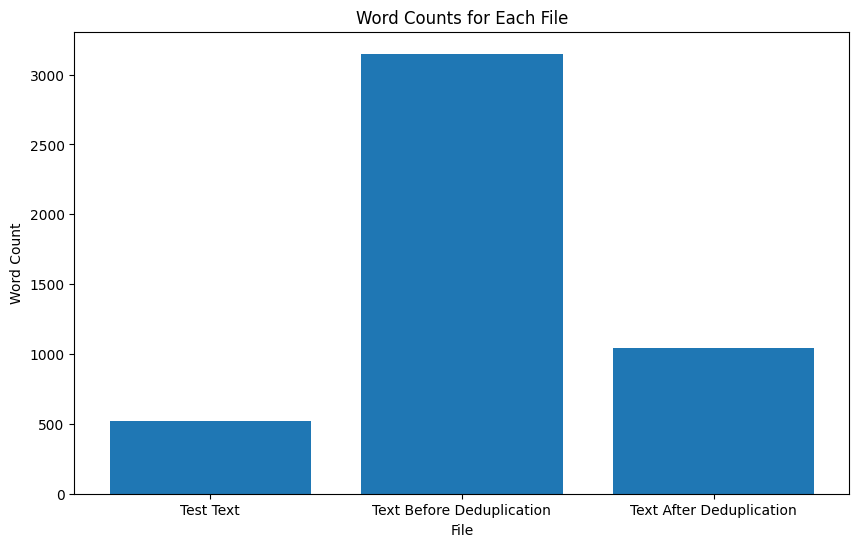

{'Test Text': 523,
 'Text Before Deduplication': 3149,
 'Text After Deduplication': 1042}

In [18]:
import matplotlib.pyplot as plt

# Define the list of file paths and their corresponding labels
file_paths = [
    ("/content/06.txt", "Test Text"),
    ("/content/cleaned_article_6.txt", "Text Before Deduplication"),
    ("/content/cleaned_text_for6_version2.txt", "Text After Deduplication")
]

# Initialize a dictionary to store word counts for each file
word_counts = {}

# Count words for each file
for file_path, label in file_paths:
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read()
        word_counts[label] = len(text.split())

# Plotting the word counts as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(word_counts.keys(), word_counts.values())
plt.xlabel("File")
plt.ylabel("Word Count")
plt.title("Word Counts for Each File")
plt.savefig("word_count_bar_chart.png")  # Save the figure
plt.show()

word_counts  # Display the word count for each file
